In [11]:
%matplotlib inline

from yapss import Problem
import numpy as np
import matplotlib.pyplot as plt
import scipy

import helpers

In [128]:
### Global settings
PASSIVE_BOT = False  # Set to True to run with zero input and simulate dynamics only
SPONG_DYNAMICS = False
TORQUE_MAX = 8  # N-m; max input magnitude

In [129]:
### Acrobot parameters (taken from Spong 1995)
# Masses (kg)
m1 = 1.
m2 = 1.
# Link lengths (m)
l1 = 1.
l2 = 2.
# Centers of masses (m)
lc1 = l1/2.
lc2 = l2/2.
# Moments of inertia
I1 = 0.083
I2 = 0.33
# Gravity
g = 9.8
# Damping coefficients
b1 = 3.
b2 = 0

### Problem parameters
t0 = 0
tf = 30
R = 10

if PASSIVE_BOT:
    if SPONG_DYNAMICS:
        x0 = [0, 0, 0, 0]
    else:
        x0 = [-np.pi/2, 0, 0, 0]
else:
    x0 = [0, 0, 0, 0]
    xf = [np.pi, 0, 0, 0]

In [130]:
### Acrobot dynamics & objective function

def dynamics_tedrake(q1, q2, q1_dot, q2_dot, u, damping=False):
    # M(q)*q_ddot + C(q, q_dot) = tau_g(q) + Bu
    # q = [q1, q2]^T
    # B = [0, 1]^T
    # Source: https://underactuated.csail.mit.edu/acrobot.html#section1,
    # but with mass matrix from DOI:10.1016/j.ifacol.2016.10.194
    # Coriolis and gravity terms match between sources (accounting for from axes conventions)

    a1 = m1*lc1**2 + m2*l1**2 + I1
    a2 = m2*lc2**2 + I2
    a3 = m2*l1*lc2

    # M, mass matrix
    # M = np.array([[I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*np.cos(q2), I2 + m2*l1*lc2*np.cos(q2)],
    #               [I2 + m2*l1*lc2*np.cos(q2), I2]])  # this is from Tedrake and is wrong
    M = np.array([[a1 + a2 + 2*a3*np.cos(q2), a2 + a3*np.cos(q2)],
                  [a2 + a3*np.cos(q2), a2]])

    # C, Coriolis terms
    C = np.array([-2*a3*np.sin(q2)*q2_dot*q1_dot - a3*np.sin(q2)*q2_dot**2,
                  a3*np.sin(q2)*q1_dot**2])

    # tau_g, gravity terms
    tau_g = np.array([-m1*g*lc1*np.sin(q1) - m2*g*(l1*np.sin(q1) + lc2*np.sin(q1 + q2)),
                      -m2*g*lc2*np.sin(q1 + q2)])
    
    # Damping terms
    if damping:
        tau_g -= np.array([b1 * q1_dot, b2 * q2_dot])

    q_ddot = helpers.inv_2x2(M) @ (-C + tau_g + np.array([0, u])).reshape((2,1))
    return [q1_dot, q2_dot, q_ddot[0,0], q_ddot[1,0]]

def dynamics_spong(q1, q2, q1_dot, q2_dot, u):
    # Source: Mark Spong, "The Swingup Control Problem for the Acrobot", IEEE Control Systems
    # Magazine, vol. 15, no. 1, pp. 49-55, February, 1995.
    d11 = m1*lc1**2 + m2*(l1**2 + lc2**2 + 2*l1*lc2*np.cos(q2)) + I1 + I2
    d22 = m2*lc2**2 + I2
    d12 = m2*(lc2**2 + l1*lc2*np.cos(q2)) + I2
    d21 = m2*(lc2**2 + l1*lc2*np.cos(q2)) + I2
    h1 = -m2*l1*lc2*np.sin(q2)*q2_dot**2 - 2*m2*l1*lc2*np.sin(q2)*q2_dot*q1_dot
    h2 = m2*l1*lc2*np.sin(q2)*q1_dot**2
    phi1 = (m1*lc1 + m2*l1)*g*np.cos(q1) + m2*lc2*g*np.cos(q1 + q2)
    phi2 = m2*lc2*g*np.cos(q1 + q2)

    det = d22 * d11 - d12 * d21
    d_inv = np.array([[d22/det, -d12/det],
                      [-d21/det, d11/det]])
    q_ddot = d_inv @ np.array([-h1 - phi1, -h2 - phi2 + u]).reshape((2,1))

    return [q1_dot, q2_dot, q_ddot[0,0], q_ddot[1,0]]

def objective(arg):
    arg.objective = arg.phase[0].integral[0]

def continuous(arg):
    q1, q2, q1_dot, q2_dot = arg.phase[0].state
    u, = arg.phase[0].control  # elbow torque

    if SPONG_DYNAMICS:
        dynamics = dynamics_spong(q1, q2, q1_dot, q2_dot, u)
    else:
        dynamics = dynamics_tedrake(q1, q2, q1_dot, q2_dot, u)

    arg.phase[0].dynamics[:] = dynamics

    if PASSIVE_BOT:
        arg.phase[0].integrand[0] = 0.
    else:
        arg.phase[0].integrand[0] = R * u**2 # Cost only on input "effort"

In [131]:
### Problem setup

# Acrobot state: [theta1, theta2, theta1_dot, theta2_dot]
# input: [torque] (at elbow joint only)
import scipy.integrate


problem = Problem(name="acrobot", nx=[4], nu=[1], nq=[1])

functions = problem.functions
functions.objective = objective
functions.continuous = continuous

## Set bounds
bounds = problem.bounds.phase[0]

# Initial conditions
bounds.initial_time.lower = bounds.initial_time.upper = t0
bounds.initial_state.lower = bounds.initial_state.upper = x0

# Final state
if not PASSIVE_BOT:
    bounds.final_state.lower = bounds.final_state.upper = xf

# Final time
bounds.final_time.lower = bounds.final_time.upper = tf

# Control bounds (torque, N*m)
if PASSIVE_BOT:
    bounds.control.lower[:] = bounds.control.upper[:] = (0,)
else:
    bounds.control.lower[:] = (-TORQUE_MAX,)
    bounds.control.upper[:] = (TORQUE_MAX,)

## Set initial guess

# TODO remove/move?
if SPONG_DYNAMICS:
    dynamics_fn = dynamics_spong
else:
    dynamics_fn = dynamics_tedrake

if PASSIVE_BOT:
    sol = scipy.integrate.solve_ivp(lambda t,y: dynamics_fn(*y, 0), [t0, tf], x0)
    state_guess = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]
else:
    # Simulate it backwards
    sol = scipy.integrate.solve_ivp(lambda t,y: dynamics_fn(*y, 0, damping=True),
                                    [t0, tf],
                                    [xf[0] - 0.02, xf[1], xf[2], xf[3]])
    state_guess = [np.flip(sol.y[0]), np.flip(sol.y[1]),
                   np.flip(-1*sol.y[2]), np.flip(-1*sol.y[3])]
    # TODO try seeding with Russ's solution

initial_guess = problem.guess.phase[0]
initial_guess.time = sol.t
initial_guess.state = state_guess
# initial_guess.control = ((0, 0),)

## Mesh and solver settings
# Prof. Hall suggested 3-400 points here
m, n = 60, 10
problem.mesh.phase[0].collocation_points = m * (n,)
problem.mesh.phase[0].mesh_fraction = m * (1.0 / m,)

problem.derivatives.order = "second"
problem.derivatives.method = "auto"
problem.spectral_method = "lgl"
problem.ipopt_options.tol = 1e-10
problem.ipopt_options.max_iter = 1000

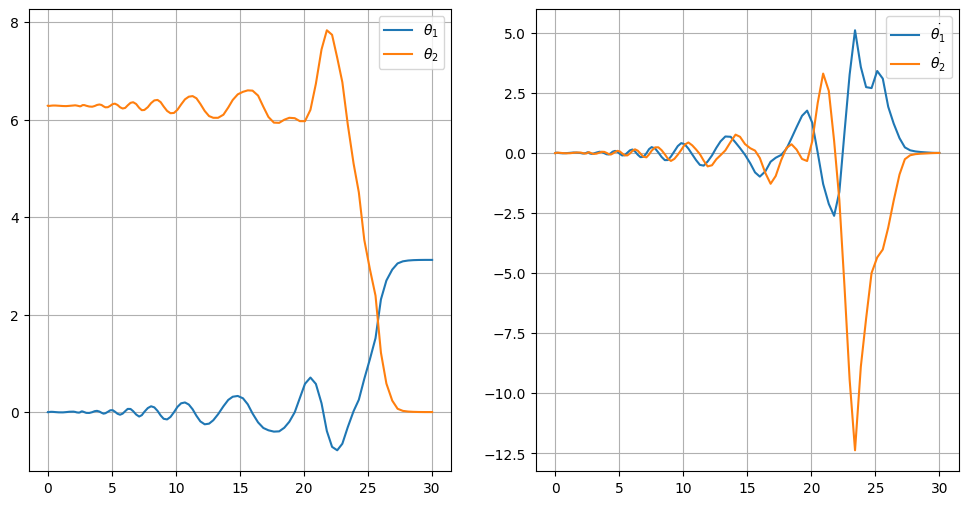

In [132]:
### Plot the initial guess
time = sol.t
q1, q2, q1_dot, q2_dot = state_guess
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(time, q1, label="$\\theta_1$")
plt.plot(time, q2, label="$\\theta_2$")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time, q1_dot, label="$\\dot{\\theta_1}$")
plt.plot(time, q2_dot, label="$\\dot{\\theta_2}$")
plt.grid()
plt.legend()

In [133]:
### Solve
output = problem.solve()

# Extract information from solution
time = output.solution.phase[0].time
time_u = output.solution.phase[0].time_u
q1, q2, q1_dot, q2_dot = output.solution.phase[0].state
(torque,) = output.solution.phase[0].control

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    31886
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5392

Total number of variables............................:     2938
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      541
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2401
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.48e+03 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

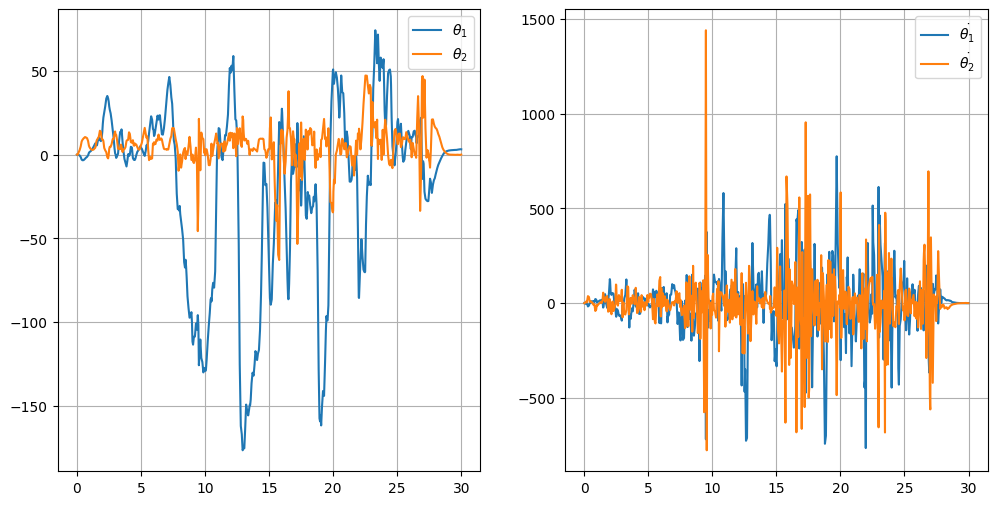

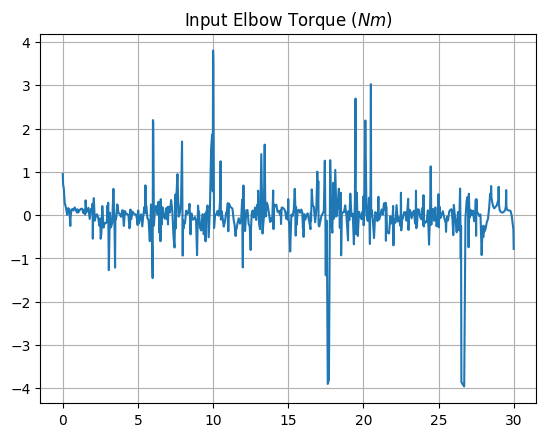

In [134]:
# Plot thetas and theta_dots
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(time, q1, label="$\\theta_1$")
plt.plot(time, q2, label="$\\theta_2$")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(time, q1_dot, label="$\\dot{\\theta_1}$")
plt.plot(time, q2_dot, label="$\\dot{\\theta_2}$")
plt.grid()
plt.legend()

# Plot torque
if not PASSIVE_BOT:
    plt.figure()
    plt.plot(time_u, torque, label="$\\tau$")
    plt.title("Input Elbow Torque ($Nm$)")
    plt.grid()

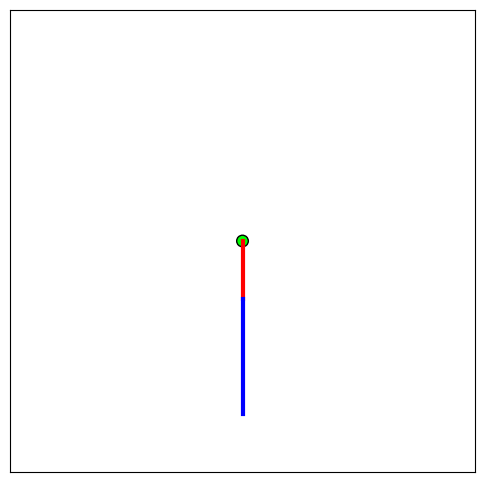

In [135]:
### Animate solution
# Adapted from: https://jckantor.github.io/CBE30338/A.03-Animation-in-Jupyter-Notebooks.html

from matplotlib import patches, animation, rc
rc("animation", html="html5")
from functools import partial

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(111)
ax1.set_xlim((-4, 4))
ax1.set_ylim((-4, 4))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

# Shoulder joint doesn't move
ax1.add_patch(patches.Circle((0, 0), 0.1, facecolor='lime', edgecolor='black'))

## Create objects that will change in the animation
# Initially empty, but will be given new values for each frame in the animation
link1, = ax1.plot([], [], 'r', lw=3)  # ax.plot returns a list of 2D line objects
link2, = ax1.plot([], [], 'b', lw=3)

## Animation function
# Must return parts of the frame that have changed in order to use blit
def drawframe_tedrake(n_frame, q1, q2):
    x1 = l1 * np.sin(q1[n_frame])
    y1 = -l1 * np.cos(q1[n_frame])
    link1.set_data([0, x1], [0, y1])
    x2 = x1 + l2 * np.sin(q1[n_frame] + q2[n_frame])
    y2 = y1 - l2 * np.cos(q1[n_frame] + q2[n_frame])
    link2.set_data([x1, x2], [y1, y2])
    return (link1, link2)

def drawframe_spong(n_frame, q1, q2):
    x1 = l1 * np.cos(q1[n_frame])
    y1 = l1 * np.sin(q1[n_frame])
    link1.set_data([0, x1], [0, y1])
    x2 = x1 + l2 * np.cos(q1[n_frame] + q2[n_frame])
    y2 = y1 + l2 * np.sin(q1[n_frame] + q2[n_frame])
    link2.set_data([x1, x2], [y1, y2])
    return (link1, link2)

## Create the animation object
# interval is in ms
# blit=True redraws only the parts that have changed
if SPONG_DYNAMICS:
    drawframe = drawframe_spong
else:
    drawframe = drawframe_tedrake
anim = animation.FuncAnimation(fig, partial(drawframe, q1=q1, q2=q2), frames=len(q1), interval=.05*1e3, blit=True)

In [136]:
anim